In [1]:
import pandas as pd
import seaborn as sns

In [3]:
learning_curves = pd.read_csv('loss.csv', index_col=0, header=[0,1])
learning_curves

training               testing            validation          
             loss     auroc        loss     auroc        loss     auroc
0      376.089590  0.477935  377.616231  0.491082  381.392692  0.519400
1       22.651148  0.500404   22.425691  0.502430   23.404768  0.487575
2       21.157405  0.445275   17.383680  0.487754   20.623855  0.439733
3        1.238069  0.449227    1.148934  0.555660    1.202731  0.529367
4       38.591800  0.473764   35.456821  0.525146   39.190470  0.508028
...           ...       ...         ...       ...         ...       ...
99995   36.839730  0.508033   38.181341  0.516595   41.140575  0.491022
99996   32.873743  0.491717   33.819236  0.503917   33.498146  0.494093
99997   32.551746  0.498038   30.720824  0.507600   32.534705  0.505797
99998   54.910368  0.506502   54.605960  0.495578   55.338476  0.504275
99999   30.189625  0.494352   29.005886  0.504605   31.025396  0.502458

[100000 rows x 6 columns]

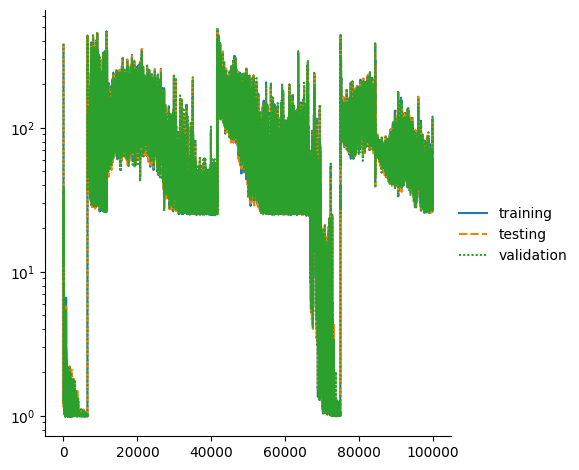

In [11]:
loss_g = sns.relplot(learning_curves.loc[:, (slice(None), 'loss')], kind='line', estimator=None)
loss_g.set(yscale = 'log')
#loss_g.set(xlim = (0, 10000))

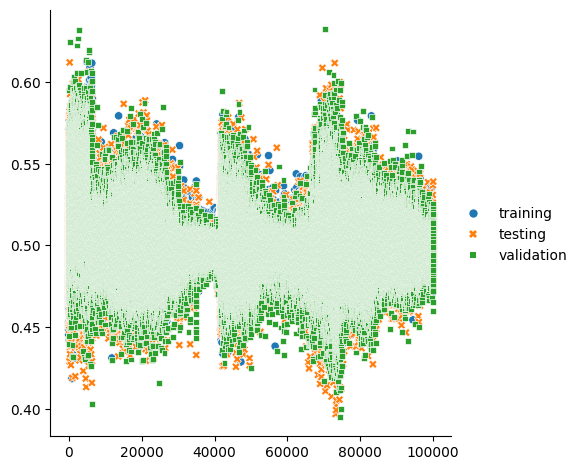

In [12]:
sns.relplot(learning_curves.loc[:, (slice(None), 'auroc')])

In [13]:
import sys
sys.path.append('..')

from train_nnc import NNConvNet
import torch

saved = torch.load('model.pt')
saved.keys()

dict_keys(['hyperparameters', 'parameters', 'best_epoch'])

In [14]:
saved['best_epoch']

70300

In [15]:
learning_curves.loc[saved['best_epoch']]

training    loss     1.820969
            auroc    0.510443
testing     loss     1.377597
            auroc    0.476929
validation  loss     1.403917
            auroc    0.632142
Name: 70300, dtype: float64

In [16]:
learning_curves.loc[:, (slice(None), 'auroc')].max(axis='index')

training    auroc    0.612232
testing     auroc    0.611716
validation  auroc    0.632142
dtype: float64

In [17]:
learning_curves.loc[:, (slice(None), 'loss')].min(axis='index')

training    loss    0.987470
testing     loss    0.979896
validation  loss    0.982392
dtype: float64

In [20]:
model = NNConvNet(**saved['hyperparameters'])
model.load_state_dict(saved['parameters'])
model.eval()

NNConvNet(
  (lin_in): Linear(in_features=18949, out_features=10, bias=True)
  (encoder): ModuleList(
    (0-1): 2 x Linear(in_features=10, out_features=10, bias=True)
  )
  (edge_nn): Sequential(
    (0): Linear(in_features=8, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (nnconv): ModuleList(
    (0-1): 2 x NNConv(10, 10, aggr=add, nn=Sequential(
      (0): Linear(in_features=8, out_features=100, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    ))
  )
  (decoder): ModuleList(
    (0-1): 2 x Linear(in_features=10, out_features=10, bias=True)
  )
  (lin_out): Linear(in_features=10, out_features=2, bias=True)
)

In [23]:
data = torch.load('../data/cpg0016_v1.pt')

In [27]:
with torch.no_grad():
    predict_df = pd.DataFrame({
        'y_hat': torch.softmax(model(data), dim=1)[:, 1],
        'y': data.y[:, 0]
    })
    predict_df['subset'] = 'Neither'
    predict_df['subset'][data.train_mask.numpy()] = 'Training'
    predict_df['subset'][data.test_mask.numpy()] = 'Testing'
    predict_df['subset'][data.val_mask.numpy()] = 'Validation'

/tmp/ipykernel_4546/2688595686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['subset'][data.train_mask.numpy()] = 'Training'
/tmp/ipykernel_4546/2688595686.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['subset'][data.test_mask.numpy()] = 'Testing'
/tmp/ipykernel_4546/2688595686.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['subset'][data.val_mask.numpy()] = 'Validation'


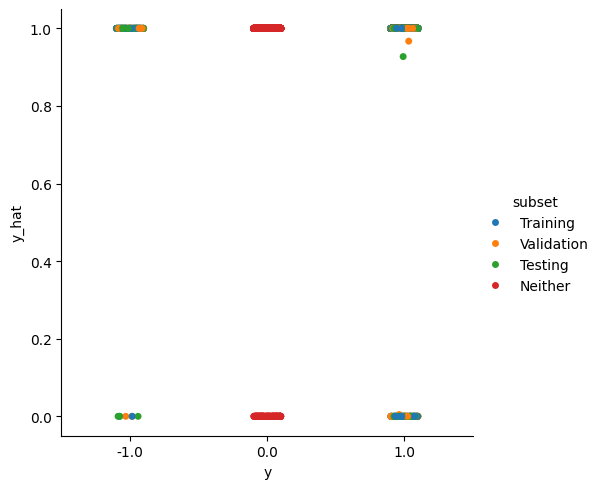

In [36]:
sns.catplot(predict_df, x='y', y='y_hat', hue='subset', kind='strip')